##                                                        Introduction
### In this kernel, I will walk you through some methods used to denoise seismic signals (and other signals in general) and explain exactly how they work. We will look at <a href='#1'>Wavelet Denoising with High-Pass Filters</a> and <a href='#1'>Average Smoothing</a>. The first method is used to remove the artificial impulse and the latter one is used to remove general noise.

<center><img src="https://i.imgur.com/hBPv3fh.png" width="750px"></center>

The main problem in the specific case of seismic signals is the fact that the signal we measure with a seismograph is not an accurate representation of the actual underground seismic signal we are trying to uncover. **In seismology, we (the people trying to measure the seismic signals) artificially generate signals called impulse signals. These impulse signals interact with the Earth's actual seismic signal (which is what we need) to produce the final signal which our seismograph picks up** (this same process takes place in the laboratory simulation of an earthquake). So, the real challenge is to uncover the actual signal from mixed seismogram (which is a combination of the Earth's impulse signal and the artificial impulse signal).

This actual underlying signal would be a better predictor of earthquake timing than the original raw signal, because it represents the actual seismic activity.

<center><img src="https://qph.fs.quoracdn.net/main-qimg-4033b6af35e7154e6b497adf0d93c2d9-c" width="300px"></center>

The third signal from the right is what we have (with artificial impulse) and the last signal from the right is what we're looking for (without the artificial impulse).

## Acknowledgements
I would like to thank Jack for [his kernel](https://www.kaggle.com/jackvial/dwt-signal-denoising) and Theo for [his kernel](https://www.kaggle.com/theoviel/fast-fourier-transform-denoising) (both on denoising).

### Import necessary libraries

In [1]:
import os
import gc
import numpy as np
from numpy.fft import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pywt 
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
import warnings
warnings.filterwarnings('ignore')

### Specify size of seismic signal segements and rate of sampling for high-pass filter

In [2]:
SIGNAL_LEN = 150000
SAMPLE_RATE = 4000

### Read data

In [9]:
seismic_signals = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

### Extract seismic data and targets and delete the original dataframe

In [10]:
acoustic_data = seismic_signals.acoustic_data
time_to_failure = seismic_signals.time_to_failure
data_len = len(seismic_signals)
del seismic_signals
gc.collect()

156

### Cut out segments of size 150k from the signal

In [11]:
signals = []
targets = []

for i in range(data_len//SIGNAL_LEN):
    min_lim = SIGNAL_LEN * i
    max_lim = min([SIGNAL_LEN * (i + 1), data_len])
    
    signals.append(list(acoustic_data[min_lim : max_lim]))
    targets.append(time_to_failure[max_lim])
    
del acoustic_data
del time_to_failure
gc.collect()
    
signals = np.array(signals)
targets = np.array(targets)

### The mean absolute deviation
This calculates the mean of the absolute values of the deviations of the individual numbers in the time series from the mean of the time series. It is a measure of entropy or disorder in the time series. The greater the MAD value, the more disorderly and unpredictable the time series is.

In [12]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

### The butterworth high-pass filter with SOS filter
A high-pass filter (HPF) is an electronic filter that passes signals with a frequency higher than a certain **cutoff frequency** and attenuates (reduces the amplitude of) signals with frequencies lower than the cutoff frequency. The amount of attenuation for each frequency depends on the filter design.

An SOS filter implements a usual [IIR filter](https://en.wikipedia.org/wiki/Infinite_impulse_response) on the [second-order sections](https://edoras.sdsu.edu/doc/matlab/toolbox/signal/basics27.html#973) of the signal.

These two filters are applied in succession in order to attenuate the unnecessary low frequency signals and prepare the signal for wavelet decomposition.

In [13]:
def high_pass_filter(x, low_cutoff=1000, SAMPLE_RATE=SAMPLE_RATE):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

## Wavelet Denoising
The filtered signals are now passed through [wavelet](https://en.wikipedia.org/wiki/Wavelet) decomposition (and the wavelet coefficients are obtained). It has to be understood that the raw signal we are working with is a convolution of the artificial and real impulse signals and this is why we need to "wavelet decomposition". The process is a sort of "deconvolution", which means it undoes the convolution process and uncovers the real Earth impulse from the mixed seismogram and the artificial impulse. We make use of the MAD value to understand the randomness in the signal and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelet coefficients and reconstruct the real Earth signal from the remaining coefficients and that's it; we have successfully removed the impulse signal from the seismogram and obtained the real Earth signal.

In [14]:
def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

### Visualize the effect of high-pass filter and wavelet denoising on seismic signals

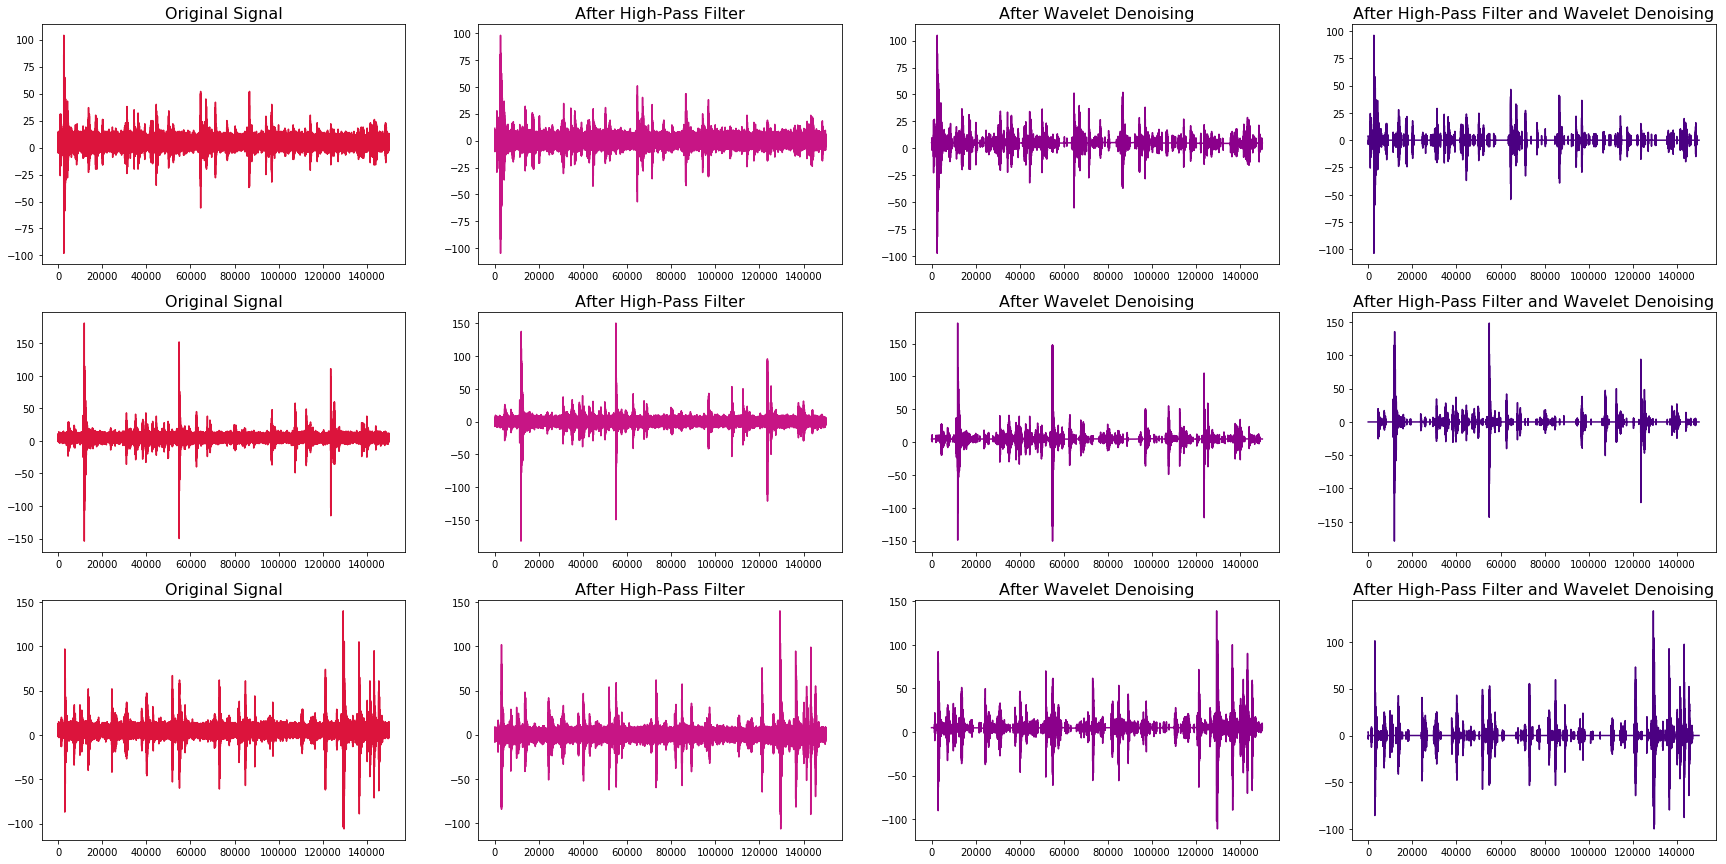

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

ax[0, 0].plot(signals[0], 'crimson') 
ax[0, 0].set_title('Original Signal', fontsize=16)
ax[0, 1].plot(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[0, 1].set_title('After High-Pass Filter', fontsize=16)
ax[0, 2].plot(denoise_signal(signals[0]), 'darkmagenta')
ax[0, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[0, 3].plot(denoise_signal(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[0, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[1, 0].plot(signals[1], 'crimson') 
ax[1, 0].set_title('Original Signal', fontsize=16)
ax[1, 1].plot(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[1, 1].set_title('After High-Pass Filter', fontsize=16)
ax[1, 2].plot(denoise_signal(signals[1]), 'darkmagenta')
ax[1, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[1, 3].plot(denoise_signal(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[1, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[2, 0].plot(signals[2], 'crimson') 
ax[2, 0].set_title('Original Signal', fontsize=16)
ax[2, 1].plot(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[2, 1].set_title('After High-Pass Filter', fontsize=16)
ax[2, 2].plot(denoise_signal(signals[2]), 'darkmagenta')
ax[2, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[2, 3].plot(denoise_signal(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[2, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

plt.show()

Clearly, we can see that the high-pass filter and wavelet denoising techniques are able to effectively denoise the signal **by removing the unnecesary artificial impulse and additional noise** from the seismic signals. The high-pass filter alone does not perform as well as the wavelet denoising alone, but **the high-pass filter followed by wavelet denoising outperforms both methods**. The wavelet method works well because it implements a sort of deconvolution process that helps remove the artificial impulse. **The high-pass filter can only filter noise and the wavelet denoising method can only remove the artificial signal, but together they can remove both**.  

**As you can see, we have achieved the same shape as the deconvolved signal in the image earlier in the kernel.**

## Average Smoothing
In this denoising method, we take a "window" with a fixed size (like 10). We first place the window at the beginning of the time series (first ten elements) and calculate the mean of that section. We now move the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. All the means we calculated are concatenated into a new time series, which is the denoised signal. 

In [16]:
def average_smoothing(signal, kernel_size, stride):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.append(np.mean(signal[start:end]))
    return np.array(sample)

### Visualize the effect of average smoothing on seismic signals (with differing kernel sizes)

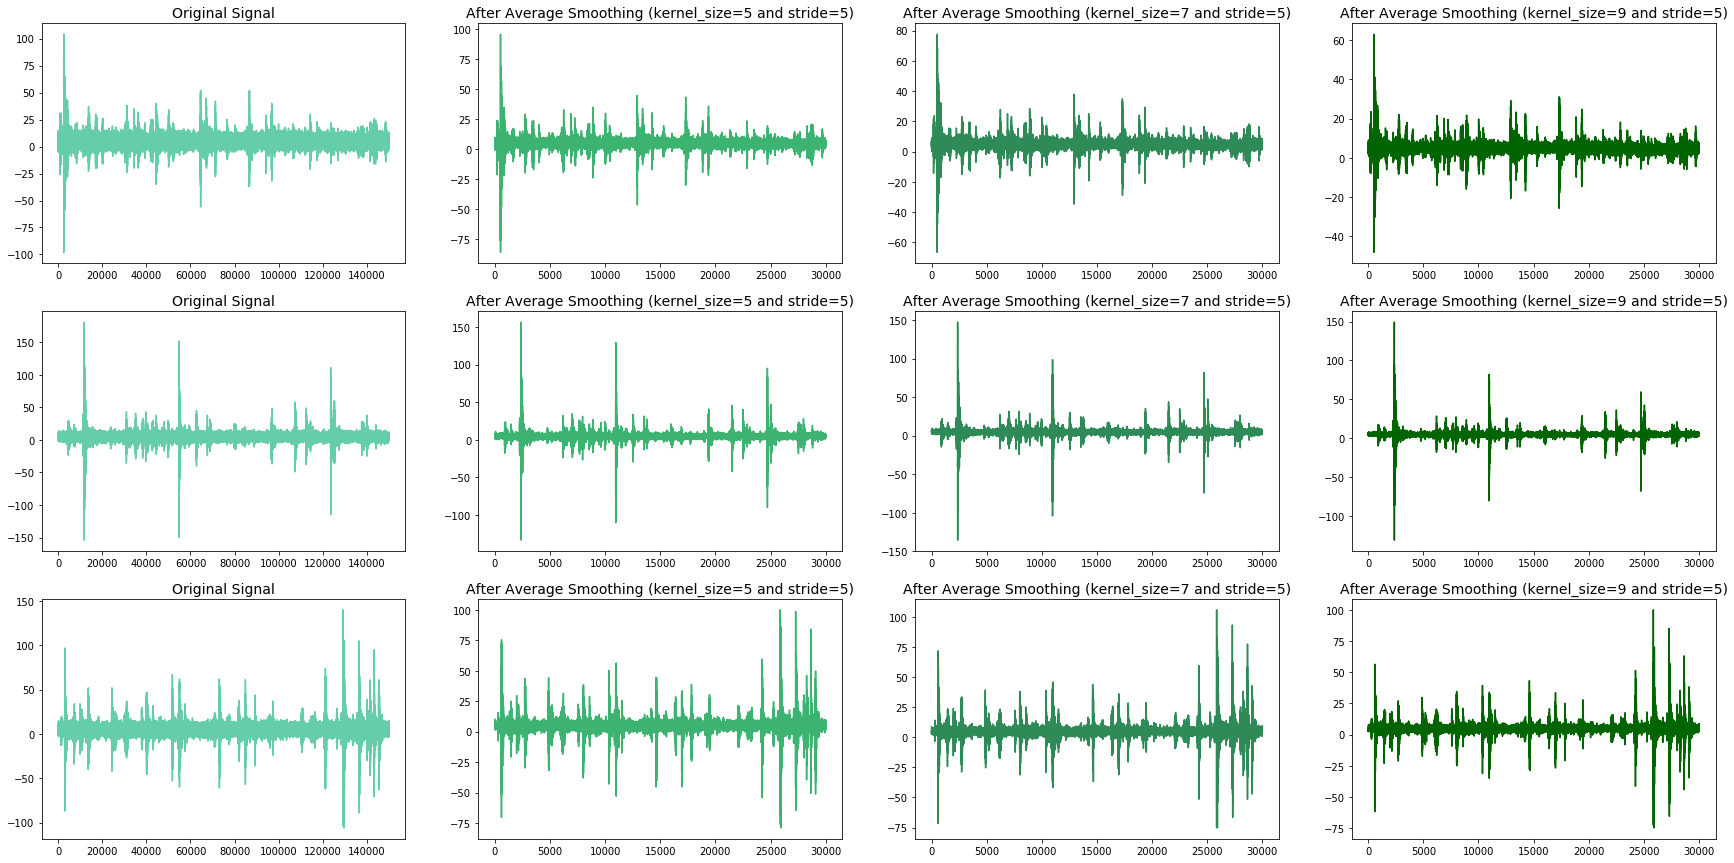

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

ax[0, 0].plot(signals[0], 'mediumaquamarine') 
ax[0, 0].set_title('Original Signal', fontsize=14)
ax[0, 1].plot(average_smoothing(signals[0], kernel_size=5, stride=5), 'mediumseagreen')
ax[0, 1].set_title('After Average Smoothing (kernel_size=5 and stride=5)', fontsize=14)
ax[0, 2].plot(average_smoothing(signals[0], kernel_size=7, stride=5), 'seagreen')
ax[0, 2].set_title('After Average Smoothing (kernel_size=7 and stride=5)', fontsize=14)
ax[0, 3].plot(average_smoothing(signals[0], kernel_size=9, stride=5), 'darkgreen')
ax[0, 3].set_title('After Average Smoothing (kernel_size=9 and stride=5)', fontsize=14)

ax[1, 0].plot(signals[1], 'mediumaquamarine') 
ax[1, 0].set_title('Original Signal', fontsize=14)
ax[1, 1].plot(average_smoothing(signals[1], kernel_size=5, stride=5), 'mediumseagreen') 
ax[1, 1].set_title('After Average Smoothing (kernel_size=5 and stride=5)', fontsize=14)
ax[1, 2].plot(average_smoothing(signals[1], kernel_size=7, stride=5), 'seagreen')
ax[1, 2].set_title('After Average Smoothing (kernel_size=7 and stride=5)', fontsize=14)
ax[1, 3].plot(average_smoothing(signals[1], kernel_size=9, stride=5), 'darkgreen')
ax[1, 3].set_title('After Average Smoothing (kernel_size=9 and stride=5)', fontsize=14)

ax[2, 0].plot(signals[2], 'mediumaquamarine') 
ax[2, 0].set_title('Original Signal', fontsize=14)
ax[2, 1].plot(average_smoothing(signals[2], kernel_size=5, stride=5), 'mediumseagreen') 
ax[2, 1].set_title('After Average Smoothing (kernel_size=5 and stride=5)', fontsize=14)
ax[2, 2].plot(average_smoothing(signals[2], kernel_size=7, stride=5), 'seagreen')
ax[2, 2].set_title('After Average Smoothing (kernel_size=7 and stride=5)', fontsize=14)
ax[2, 3].plot(average_smoothing(signals[2], kernel_size=9, stride=5), 'darkgreen')
ax[2, 3].set_title('After Average Smoothing (kernel_size=9 and stride=5)', fontsize=14)

plt.show()

We can see that the average smoothing method is **only able to remove some additional noise, but not the artificial impulse as it is only able to smooth the curve**.

**The high amplitude, unstable parts of the signal (with high peaks and valleys) are the actual signal we are looking for. The medium amplitude patches of the signal (between the high amplitude regions) represent the unnecessary noise and artificial impulse, and the wavelet method seems to do better at removing these patches. This denoising illustrated in the image at the beginning of the kernel.**

**We can therefore conclude that the wavelet denoising method is overall more effective than the average smoothing method.**

**I believe that denoising the signals can significantly boost the scores of all the models (NN or LightGBM).**

### That's it ! Thanks for reading my kernel ! Hope you found it useful :)

In [18]:
# Save Data
signals

array([[12,  6,  8, ...,  6,  2,  0],
       [ 5,  6,  8, ...,  7,  7,  5],
       [ 5,  5,  8, ...,  5,  8,  3],
       ...,
       [ 2, -1,  0, ...,  2,  6,  7],
       [ 9,  7,  5, ...,  2,  5,  4],
       [ 1,  2,  3, ...,  9,  7,  5]])